## Ultimate Tech Take Home Challenge

Report prepared by Ben Chamblee: https://github.com/Bench-amblee 

## Contents:

* [Part 1 - Exploratory Data Analysis](#Part_1)  
* [Part 2 - Experiment and Metrics Design](#Part_2)  
* [Part 3 - Predictive Modeling](#Part_3)  
* [Conclusion](#Conclusion)

## Part 1<a id='Part_1'></a>

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#modeling
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from scipy.stats import ttest_ind
from sklearn.model_selection import GridSearchCV

logins = pd.read_json('logins.json',convert_dates=True)
ultimate = pd.read_json('ultimate_data_challenge.json')

In [2]:
from copy import deepcopy
#adding a counter for each login so we can group by days and 15 minutes
logins_count = deepcopy(logins)
logins_count["count"] = 1
logins_count = logins_count.set_index("login_time")
logins_count_15min = logins_count.groupby(pd.Grouper(freq="15Min")).sum()
logins_count_15min.index.name = "DateTime"

Text(0.5, 1.0, 'Login rate by day')

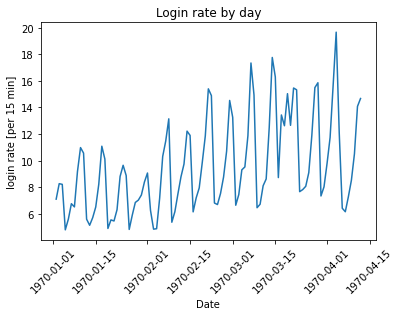

In [3]:
logins_count_byday = logins_count_15min.groupby(logins_count_15min.index.date).mean()
logins_count_byday = logins_count_byday[1 : -1]
logins_count_byday.index.name = "Date"

logins_count_byday.plot(y="count", rot=45, legend=None)
plt.ylabel("login rate [per 15 min]")
plt.title("Login rate by day")

Looks like there is a noticeable trend of ups and downs, my guess is that is has something to do with employees logging in on the weekdays but not as much on the weekends. 

Lets take a closer look:

Text(0.5, 1.0, 'Login rate by day of week')

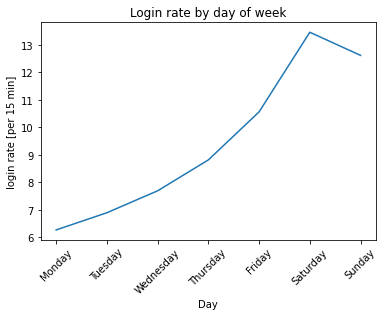

In [4]:
#plot for each day of the week

logins_count_week = logins_count_15min["1970-01-02" : "1970-04-12"].groupby(logins_count_15min["1970-01-02" : "1970-04-12"].index.weekday).mean()
logins_count_week.index.name = "Day"

logins_count_week.plot(y="count", rot=45, legend=None)
plt.xticks(ticks=range(7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.ylabel("login rate [per 15 min]")
plt.title("Login rate by day of week")

Text(0.5, 1.0, 'Login rate by hour')

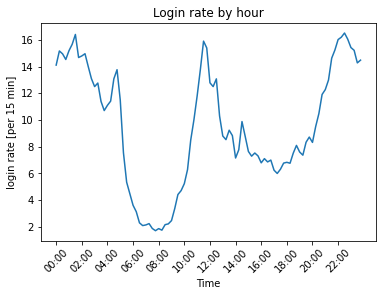

In [5]:
#plot for each hour

from matplotlib.dates import HourLocator

logins_count_average_day = logins_count_15min.groupby(logins_count_15min.index.time).mean()
logins_count_average_day.index.name = "Time"

logins_count_average_day.plot(y="count",rot=45, legend=None)
plt.xticks([7200 * h for h in range(12)])
plt.ylabel("login rate [per 15 min]")
plt.title("Login rate by hour")

This is just an average but it looks like there are two noticable peaks at around     
11:00 AM - 1:00 PM and 10:00 PM - 5:00 AM

Text(0.5, 1.0, 'Hourly login rate on different days of week')

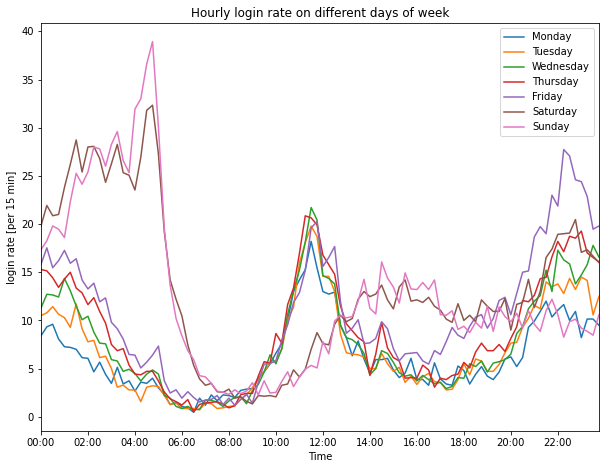

In [6]:
#ploting average time for each day of the week

pd.plotting.register_matplotlib_converters()

logins_count_average_dayofweek_time = logins_count_15min.groupby([logins_count_15min.index.weekday, logins_count_15min.index.time]).mean()

day_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.figure(figsize=(10, 7.5))
for i in range(7):
    plt.plot(logins_count_average_dayofweek_time.loc[i], label=day_of_week[i])
plt.ylabel("login rate [per 15 min]")
plt.xticks([7200 * h for h in range(12)])
plt.xlabel("Time")
plt.legend(loc="upper right")
plt.xlim([0, 3600 * 23.75])
plt.title("Hourly login rate on different days of week")

Looks like the peaks are different based on whether or not it is a weekend or weekday. On the weekends the peak is in the early morning like 2:00 AM - 5:00 AM

While on the weekday it's around 12:00 PM, possibly lunch?

Text(0.5, 1.0, 'Trend in Average Login Rate')

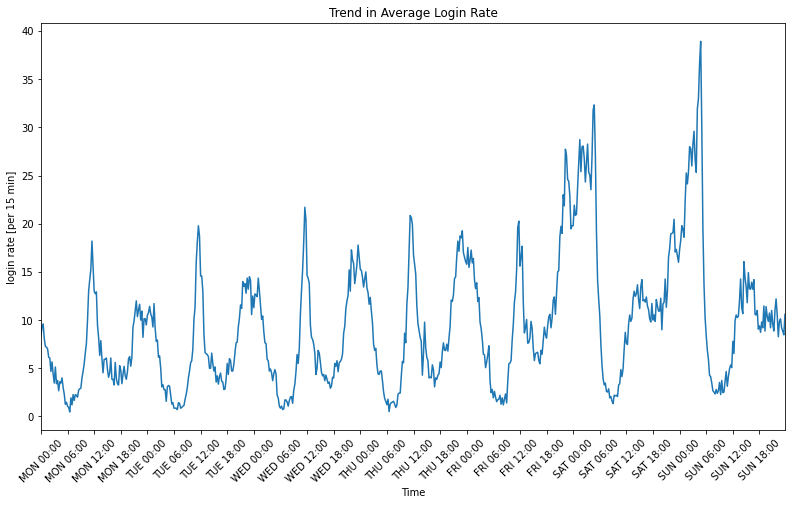

In [7]:
from itertools import product

timeIndex = [i * 15 for i in range(len(logins_count_average_dayofweek_time))]

plt.figure(figsize=(40/3, 7.5))
plt.plot(timeIndex, logins_count_average_dayofweek_time["count"])
day_of_week = ["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"]
xlabels = list(map(lambda x: x[0] + " " + x[1], product(day_of_week, ["00:00", "06:00", "12:00", "18:00"])))
plt.xlabel("Time")
plt.xticks([i * 6 * 60 for i in range(4 * 7)], xlabels, rotation=45)
plt.xlim([0, 60 * (24 * 6 + 23.75)])
plt.ylabel("login rate [per 15 min]")
plt.title('Trend in Average Login Rate')

Here we can see the trend in the average login rate, overal it looks like there has been a recent increase it login rate for both weekday and weekend logins.

## Part 2<a id='Part_2'></a>

There are a lot of options for potential KPIs in this scenario. Some of these possible KPIs are: 
* Revenue 
* Number of bridge crossings 
* Ratio of dropoffs/pickups that occur outside the typically preferred city of the driver.

The total number of bridge crossings is probably not a good indicator, because it's impossible to tell how long each driver spends in each city and it doesn't really measure the 'availability' of the drivers. Same thing with revenue, which can also be changed by many different factors. Therefore, I believe that the ratio of dropoffs/pickups that occur outside of a drivers typically preferred city would be the best KPI.

My method for testing this will be as follows:

* Pick a previous time period to test against, the login data shows clear daily and weekly patterns.
* Calculate the total number of dropoffs and pickups and the total percentage that happened outisde of the preferred city.
* The preferred city will be defined as the city where over half of the pickups/dropoffs occured

Using this I can test different values, like the proposed toll changes, then using statistical analysis I can determine whether or not the changes will improve availability for the drivers in each city.

## Part 3<a id='Part_3'></a>

In [8]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [9]:
# assume the reference date is the latest date in last_trip_date
ultimate.last_trip_date = pd.to_datetime(ultimate.last_trip_date)
ultimate.signup_date = pd.to_datetime(ultimate.signup_date)

In [10]:
sorted(ultimate.last_trip_date)[-1]

Timestamp('2014-07-01 00:00:00')

In [11]:
# the retained cutoff will be 6-1, 1 month before the last date
retained_cutoff = pd.to_datetime('2014-06-01')

# we can then add this as a yes or no column
ultimate["retained"] = ultimate.apply(lambda row: 1 if row["last_trip_date"] > retained_cutoff else 0, axis=1)

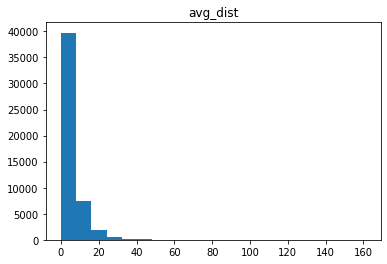

C:\Users\Benja\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Benja\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


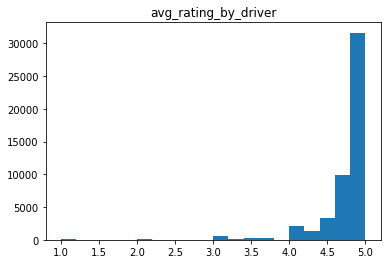

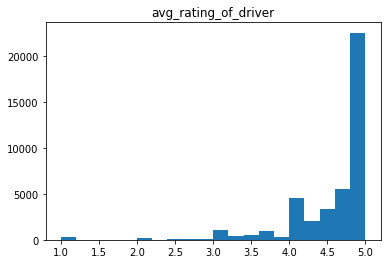

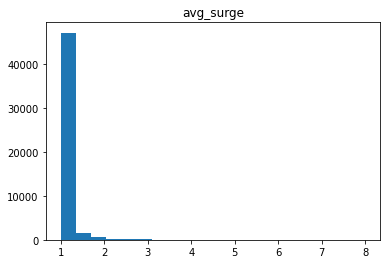

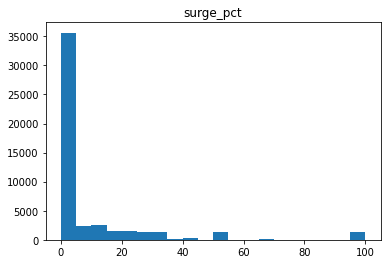

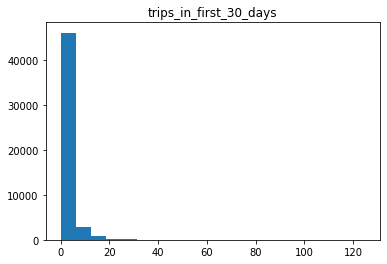

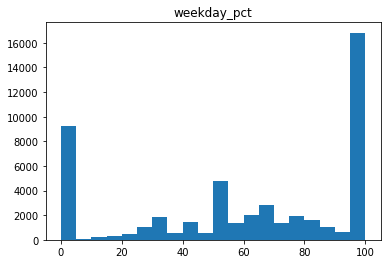

In [12]:
#Plot distributions
continuous_cols = ["avg_dist", "avg_rating_by_driver","avg_rating_of_driver", "avg_surge", "surge_pct", "trips_in_first_30_days", "weekday_pct"]

for col in continuous_cols:
    plt.hist(ultimate[col], bins=20)
    plt.title(col)
    plt.show()

In [13]:
# clean data by imputing means for avg, and drop remaining rows
ultimate.avg_rating_by_driver = ultimate.avg_rating_by_driver.replace(np.nan, ultimate.avg_rating_by_driver.mean())
ultimate.avg_rating_of_driver = ultimate.avg_rating_of_driver.replace(np.nan, ultimate.avg_rating_of_driver.mean())

ultimate.dropna(inplace=True, axis=0)
ultimate.reset_index(inplace=True)
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49604 entries, 0 to 49603
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   index                   49604 non-null  int64         
 1   city                    49604 non-null  object        
 2   trips_in_first_30_days  49604 non-null  int64         
 3   signup_date             49604 non-null  datetime64[ns]
 4   avg_rating_of_driver    49604 non-null  float64       
 5   avg_surge               49604 non-null  float64       
 6   last_trip_date          49604 non-null  datetime64[ns]
 7   phone                   49604 non-null  object        
 8   surge_pct               49604 non-null  float64       
 9   ultimate_black_user     49604 non-null  bool          
 10  weekday_pct             49604 non-null  float64       
 11  avg_dist                49604 non-null  float64       
 12  avg_rating_by_driver    49604 non-null  float6

Now that our data is all the same size, we can move on:

In [14]:
categorical_data = ultimate.loc[:,["city", "phone", "ultimate_black_user"]]
encoder = OneHotEncoder(categories="auto", sparse=False, drop='first')
enc_cat_data = pd.DataFrame(encoder.fit_transform(categorical_data))
enc_cat_data.columns = encoder.get_feature_names()
modified_ultimate = ultimate.drop(["city", "phone", "ultimate_black_user", "last_trip_date", "signup_date","index"], axis=1)
modified_ultimate = modified_ultimate.join(enc_cat_data, how="left")
modified_ultimate.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained,x0_King's Landing,x0_Winterfell,x1_iPhone,x2_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,1,1.0,0.0,1.0,1.0
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0,0.0,0.0,0.0,0.0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0,0.0,0.0,1.0,0.0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1,1.0,0.0,1.0,1.0
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0.0,1.0,0.0,0.0


In [15]:
modified_ultimate.retained.mean()

0.3665027013950488

This means  that 36.6% of drivers were retained

In [16]:
#create a train test split
X = modified_ultimate.drop("retained", axis=1)
y = modified_ultimate[["retained"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
#create gridsearch cross validation
n_estimator_space = [50, 100, 200]
max_features_space = [2, 'sqrt', 5, 10]
class_weight_space = ['balanced', 'balanced_subsample', None]
criterion_space = ['gini', 'entropy']
param_grid = {'n_estimators': n_estimator_space, 
              'max_features': max_features_space, 
              'class_weight': class_weight_space, 
              'criterion': criterion_space}
rf_tune = RandomForestClassifier(random_state=42)
rf_cv = GridSearchCV(rf_tune, param_grid, cv=3, scoring='roc_auc')
rf_cv.fit(X_train, y_train.values.ravel())
print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_features': 5, 'n_estimators': 200}
0.8286823365955892


In [18]:
#create random forest model
rf = RandomForestClassifier(n_estimators = 200, 
                            max_features='sqrt', 
                            random_state=42, 
                            criterion='entropy', 
                            class_weight='balanced_subsample')

rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)

print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

print("Classification Report")
print(metrics.classification_report(y_test, y_pred))

Confusion Matrix:
[[5163 1122]
 [1219 2417]]
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      6285
           1       0.68      0.66      0.67      3636

    accuracy                           0.76      9921
   macro avg       0.75      0.74      0.74      9921
weighted avg       0.76      0.76      0.76      9921



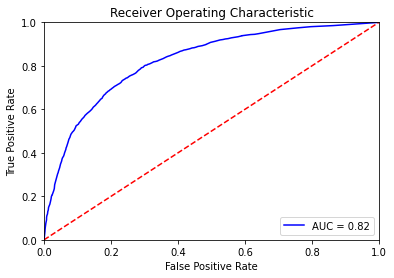

In [20]:
#ROC Curve
probs = y_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, probs, pos_label=1.)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

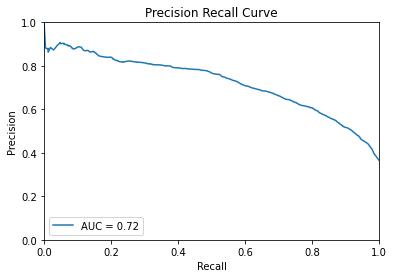

In [21]:

#Precision Recall Curve
probs = y_prob[:,1]
precision, recall, thresholds = metrics.precision_recall_curve(y_test, probs, pos_label=1.)
prc_auc = metrics.auc(recall, precision)

plt.title("Precision Recall Curve")
plt.plot(recall, precision, label= 'AUC = %0.2f' % prc_auc)
plt.legend(loc = 'lower left')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [22]:
#Feature importances
feature_importances = pd.DataFrame()
feature_importances["feature"] = X_train.columns
feature_importances["importance"] = rf_model.feature_importances_
feature_importances.sort_values(by='importance', ascending=False).head(20)

,feature,importance
5,avg_dist,0.329537
4,weekday_pct,0.129113
6,avg_rating_by_driver,0.103167
1,avg_rating_of_driver,0.086336
0,trips_in_first_30_days,0.082634
3,surge_pct,0.069414
2,avg_surge,0.061444
7,x0_King's Landing,0.056988
9,x1_iPhone,0.037268
10,x2_True,0.027539


Looks like the most important features are:
* average distance per trip
* percentage of weekday trips
* average rating by driver

Let's take a closer look at each one:

Not retained mean: 6.1716878818737335
Retained mean: 5.117754125412585


Ttest_indResult(statistic=-21.5741770773489, pvalue=1.0075122966990254e-102)

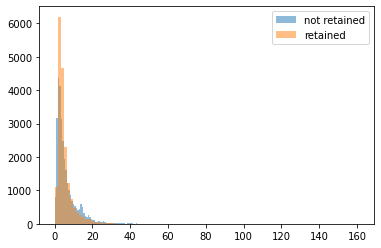

In [19]:
#Inspect Average Distance
retained = modified_ultimate.loc[modified_ultimate.retained == 1]["avg_dist"]
not_retained = modified_ultimate.loc[modified_ultimate.retained == 0]["avg_dist"]

plt.hist(not_retained, bins = 100, alpha=0.5, label="not retained")
plt.hist(retained, bins = 100, alpha=0.5, label="retained")
plt.legend()
plt.show

print("Not retained mean: {}".format(not_retained.mean()))
print("Retained mean: {}".format(retained.mean()))
ttest_ind(retained, not_retained, equal_var=False)

Looks like users that are retained tend to take shorter trips

Not retained mean: 4.786389954943171
Retained mean: 4.763121968023268


Ttest_indResult(statistic=-6.250880169168685, pvalue=4.114963557381491e-10)

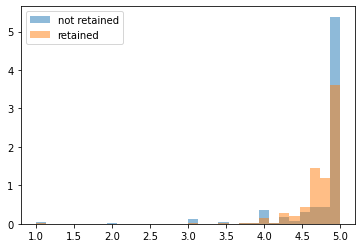

In [23]:
#Inspect Average Rating by Driver
retained = modified_ultimate.loc[modified_ultimate.retained == 1]["avg_rating_by_driver"]
not_retained = modified_ultimate.loc[modified_ultimate.retained == 0]["avg_rating_by_driver"]

plt.hist(not_retained, bins = 30, alpha=0.5, label="not retained", density=True)
plt.hist(retained, bins = 30, alpha=0.5, label="retained", density=True)
plt.legend()
plt.show

print("Not retained mean: {}".format(not_retained.mean()))
print("Retained mean: {}".format(retained.mean()))
ttest_ind(retained, not_retained, equal_var=False)

Looks like users that are retained have lower average ratings by the driver, but this might be slightly biased because not all users are retained and not all of them make reviews so only a small percentage actually give out these ratings

Not retained mean: 60.139282077392906
Retained mean: 62.17078107810796


Ttest_indResult(statistic=6.42352351772281, pvalue=1.3440868825810925e-10)

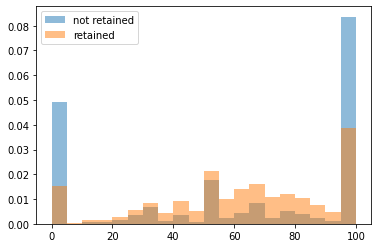

In [25]:
#Inspect Weekday Percentage
retained = modified_ultimate.loc[modified_ultimate.retained == 1]["weekday_pct"]
not_retained = modified_ultimate.loc[modified_ultimate.retained == 0]["weekday_pct"]

plt.hist(not_retained, bins = 20, alpha=0.5, label="not retained", density=True)
plt.hist(retained, bins = 20, alpha=0.5, label="retained", density=True)
plt.legend()
plt.show

print("Not retained mean: {}".format(not_retained.mean()))
print("Retained mean: {}".format(retained.mean()))
ttest_ind(retained, not_retained, equal_var=False)

Just like before most of the results fall in either 0 or 100, but the numbers in between are most interesting. The middle population probably represents the small population of users that have used the service multiple times, while the larger outliers represent the population that has used the service one or zero times.

## Conclusion

Based on these results we can conclude that retained users have a shorter average distance of trips. This information is useful because it could be used to help Ultimate retain more of their users. Perhaps the company could perform some AB testing to find a way to benefit riders that take shorter trips? This might include a loyalty program which for example might have benefits like reduced fees or anythign else to incentivize shorter trips and more retained users. There is still a lot of profit to be made from long trips though so there also needs to be some balance for those users.